In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from scipy.io import loadmat
from torchvision.transforms import ToTensor
import numpy as np

import matplotlib.pyplot as plt

In [15]:
# hypothetical new dataset class with both types of data

ACTION_MAP = {
    'baseball_pitch': 0, 'baseball_swing': 1, 'bench_press': 2, 'bowl': 3,
    'clean_and_jerk': 4, 'golf_swing': 5, 'jump_rope': 6, 'jumping_jacks': 7,
    'pullup': 8, 'pushup': 9, 'situp': 10, 'squat': 11,
    'strum_guitar': 12, 'tennis_forehand': 13, 'tennis_serve': 14
}

# map of all joints
Joint_Map = {"head" : 0,"left_shoulder" : 1,"right_shoulder" : 2,"left_elbow" : 3,
          "right_elbow" : 4,"left_wrist" : 5,"right_wrist" : 6,"left_hip" : 7,"right_hip" : 8,
          "left_knee" : 9,"right_knee" : 10,"left_ankle" : 11,"right_ankle" : 12}

class TestBothDataPennActionDataset(Dataset):
    def __init__(self, frames_dir, labels_dir, transform=None):
        self.frames_dir = frames_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.frame_paths = []
        self.action_labels = []
        self.joint_labels = []
        
        image_sequence_folders = sorted(os.listdir(frames_dir))
        
        for seq_folder in image_sequence_folders:
            if seq_folder != ".DS_Store":
                seq_frames_path = os.path.join(frames_dir, seq_folder)
                frames = sorted(os.listdir(seq_frames_path))
                if frames[0] == ".DS_Store":
                    frames.remove(".DS_Store")
                frame_path = os.path.join(seq_frames_path, frames[0])
                
                self.frame_paths.append(frame_path)
                
                label_path = os.path.join(labels_dir, seq_folder + '.mat')
                mat = loadmat(label_path)
                annotation = [[float(mat["x"][0][i]), float(mat["y"][0][i]), float(mat["visibility"][0][i])] for i in
                         range(len(Joint_Map))]
                action_label = mat['action'][0]

                # need to work on this
                self.joint_labels.append(annotation)
                #

                self.action_labels.append(ACTION_MAP[action_label])
    
    def __getitem__(self, idx):
        img_path = self.frame_paths[idx]
        img = Image.open(img_path)
        annotation = self.joint_labels[idx]
        if self.transform:
            img = self.transform(img)
        annotation = torch.tensor(annotation)
        label = torch.tensor(self.action_labels[idx])
        return [img,annotation], label

    def __len__(self):
        return len(self.frame_paths)

In [18]:
# joint_training_data = PENNDataset(
#     csv_file  = "../Penn_Action/TrainTable.csv",
#     root_dir="root",
#     transform=ToTensor()
# )
# join_test_data = PENNDataset(
#     csv_file = "../Penn_Action/TrainTable.csv",
#     root_dir="root",
#     transform=ToTensor()
# )

In [19]:
# Convert to Tensor 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalize
])

# Load dataset
frames_dir = "/Users/gamep/Downloads/Penn_Action/Penn_Action/frames"
labels_dir = "/Users/gamep/Downloads/Penn_Action/Penn_Action/labels"

dataset = TestBothDataPennActionDataset(frames_dir, labels_dir, transform=transform)

In [22]:
class PartiallyConnectedCNN(nn.Module):
    def __init__(self):
        super(PartiallyConnectedCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.image_conv_relu_stack = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.ReLU()
        )
        self.image_linear_stack = nn.Sequential(
            nn.Linear(100352 , 128),
            nn.Sigmoid(),
            nn.Linear(128, 32),
            nn.Sigmoid(),
            nn.Linear(32, 15),
            nn.LogSoftmax(dim=0)
        )
        self.joint_conv_relu_stack = nn.Sequential(
                                               nn.Conv1d(in_channels=13, out_channels=39, kernel_size = 1),
                                               nn.ReLU(),
                                               
                                                nn.Conv1d(in_channels=39, out_channels=39, kernel_size = 1),
                                               nn.ReLU(),
                                               nn.Conv1d(in_channels=39, out_channels=39, kernel_size = 1),
                                               nn.ReLU()
        )
        self.joint_linear = nn.Sequential(nn.Linear(117,512),
                                        nn.Sigmoid(),
                                        nn.Linear(512,15),
                                        nn.LogSoftmax(dim=0))
        self.combined_linear = nn.Sequential(
            nn.Linear(30,15),
        )


    def forward(self, input):
        x = input[0]
        y = input[1]
        
        x = self.image_conv_relu_stack(x)
        x = self.flatten(x)
        x = self.image_linear_stack(x)
        y = self.joint_conv_relu_stack(y)
        y = self.flatten(y)
        y = self.joint_linear(y)
        final = torch.cat((x,y),dim=1)
        self.combined_linear(final);

        
        return final

In [23]:
# Split dataset to train and test 
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = PartiallyConnectedCNN().to(device)

Using device: cpu


In [24]:
# Cross-entropy loss as the loss function
loss_fn = nn.CrossEntropyLoss()

#optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
train_losses = []
test_accuracies = []
testing = False
epochs = 30
for epoch in range(epochs):
    if(not testing):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # training 
        for inputs, labels in train_loader:
            #inputs, labels = inputs.to(device), labels.to(device)

            # backpropagation 
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()  # weight update 
        
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # testing 
    # Set model to eval mode 
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            #inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    test_accuracies.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {val_loss/len(test_loader):.4f}, "
            f"Accuracy: {100 * val_correct/val_total:.2f}% ")


Epoch 1/30, Loss: 2.6996, Accuracy: 24.30% 
Epoch 2/30, Loss: 2.4895, Accuracy: 28.35% 
Epoch 3/30, Loss: 2.3283, Accuracy: 31.65% 
Epoch 4/30, Loss: 2.2243, Accuracy: 36.20% 
Epoch 5/30, Loss: 2.1239, Accuracy: 37.22% 
Epoch 6/30, Loss: 2.1392, Accuracy: 40.51% 
Epoch 7/30, Loss: 2.0354, Accuracy: 40.76% 
Epoch 8/30, Loss: 2.0802, Accuracy: 42.28% 
Epoch 9/30, Loss: 2.0263, Accuracy: 41.77% 
Epoch 10/30, Loss: 1.9678, Accuracy: 41.52% 
Epoch 11/30, Loss: 1.9971, Accuracy: 42.03% 
Epoch 12/30, Loss: 2.0234, Accuracy: 43.29% 
Epoch 13/30, Loss: 2.0173, Accuracy: 42.53% 
Epoch 14/30, Loss: 2.0061, Accuracy: 44.05% 
Epoch 15/30, Loss: 2.0470, Accuracy: 44.05% 
Epoch 16/30, Loss: 2.1624, Accuracy: 43.80% 
Epoch 17/30, Loss: 2.0713, Accuracy: 43.54% 
Epoch 18/30, Loss: 2.1022, Accuracy: 44.56% 
Epoch 19/30, Loss: 2.0614, Accuracy: 44.56% 
Epoch 20/30, Loss: 2.1870, Accuracy: 43.54% 
Epoch 21/30, Loss: 2.2534, Accuracy: 41.27% 
Epoch 22/30, Loss: 2.2458, Accuracy: 44.81% 
Epoch 23/30, Loss: 

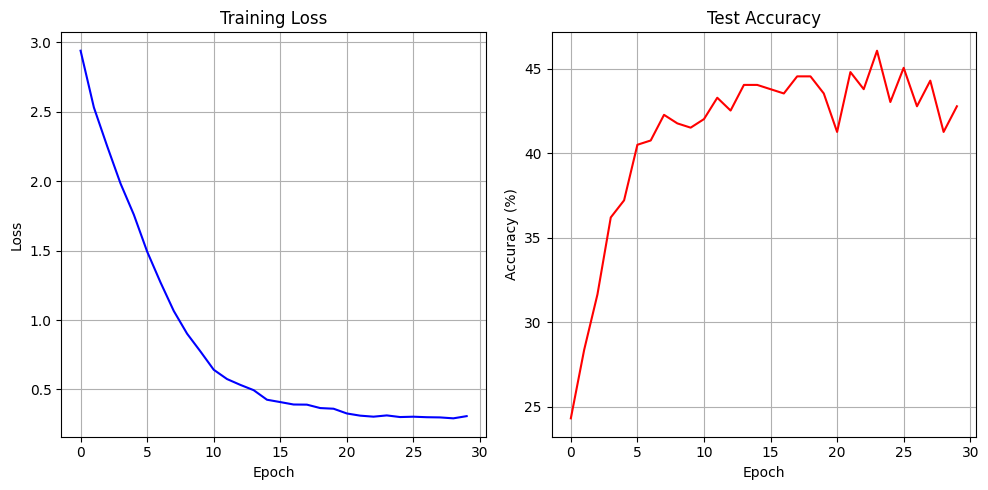

In [26]:
# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(epochs), test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()